In [29]:
import numpy as np
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

print(tf.__version__)

2.3.0


# Get data

In [2]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
# check how much data
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

3670

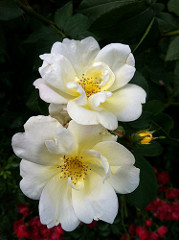

In [4]:
# check a sample image
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

# Load data using keras.preprocessing

In [5]:
# parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

# use keras.preprocessing to load images into dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width), # resizes the images to img_height and img_width, can also use a keras resizing layer
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
# dataset has a class_names attribute
class_names = train_ds.class_names
print(class_names)

[&#39;daisy&#39;, &#39;dandelion&#39;, &#39;roses&#39;, &#39;sunflowers&#39;, &#39;tulips&#39;]


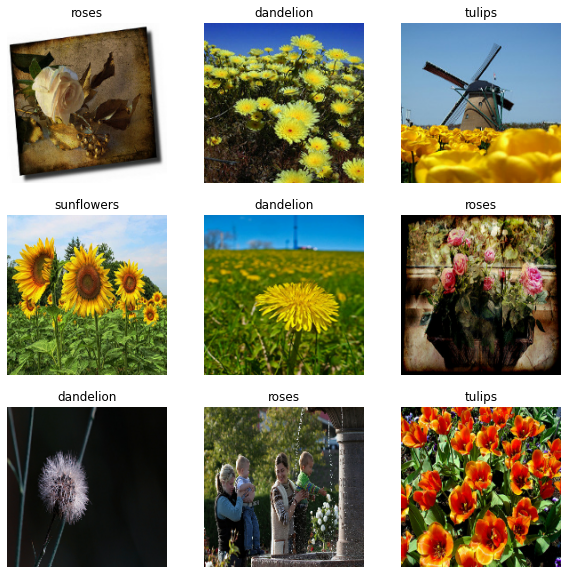

In [8]:
# visualize data
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape) # a batch is 32 images with 180x180, 3 channels
    print(labels_batch.shape) # a batch is 32 labels
    break

(32, 180, 180, 3)
(32,)


### standarize data

In [10]:
# create an normalization layer that will normalize the pixel value to [0, 1]
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [11]:
# can use the map function on the dataset to use the normalization layer
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image)) # now is in [0, 1] range

0.0 0.96902645


### configure dataset

In [12]:
# cache() and prefetch() will increase efficiency of datasets
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### train model

In [13]:
num_classes = 5

model = tf.keras.Sequential([
    normalization_layer, # can also include the layer in the model construction, then don't need to use dataset.map()
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [15]:
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 8s 90ms/step - loss: 1.3024 - accuracy: 0.4475 - val_loss: 1.1274 - val_accuracy: 0.5436
Epoch 2/3
92/92 [==============================] - 3s 35ms/step - loss: 1.0656 - accuracy: 0.5753 - val_loss: 1.0293 - val_accuracy: 0.6144
Epoch 3/3
92/92 [==============================] - 3s 35ms/step - loss: 0.9282 - accuracy: 0.6390 - val_loss: 0.9685 - val_accuracy: 0.6008


&lt;tensorflow.python.keras.callbacks.History at 0x1e8edd86b50&gt;

# Load data using tf.data customization

In [16]:
# read all the image paths into a list
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [17]:
for f in list_ds.take(5):
    print(f.numpy())

b&#39;C:\\Users\\kevin\\.keras\\datasets\\flower_photos\\roses\\3253243865_435c1f2c2b_m.jpg&#39;
b&#39;C:\\Users\\kevin\\.keras\\datasets\\flower_photos\\dandelion\\5605502523_05acb00ae7_n.jpg&#39;
b&#39;C:\\Users\\kevin\\.keras\\datasets\\flower_photos\\roses\\16772483324_09f24813a1_n.jpg&#39;
b&#39;C:\\Users\\kevin\\.keras\\datasets\\flower_photos\\roses\\12407768513_3440238148_n.jpg&#39;
b&#39;C:\\Users\\kevin\\.keras\\datasets\\flower_photos\\tulips\\135994133_4f306fe4bf_n.jpg&#39;


In [18]:
# extract the class names
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

[&#39;daisy&#39; &#39;dandelion&#39; &#39;roses&#39; &#39;sunflowers&#39; &#39;tulips&#39;]


In [19]:
# train and val set
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [20]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


In [23]:
# functions to convert file path to (img, label)

# function to get label
def get_label(file_path):
    # convert path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # get the class directory
    one_hot = parts[-2] == class_names
    # integer encode the label
    return tf.argmax(one_hot)

# function to decode image read into tensor
def decode_img(img):
    # convert compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize image
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    label = get_label(file_path)
    # load img as string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [24]:
# use Dataset.map() using the functions to create a dataset of (image, label)
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [25]:
# check the converted dataset (from text lists to image, label)
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


### configure dataset

In [26]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### visualize data

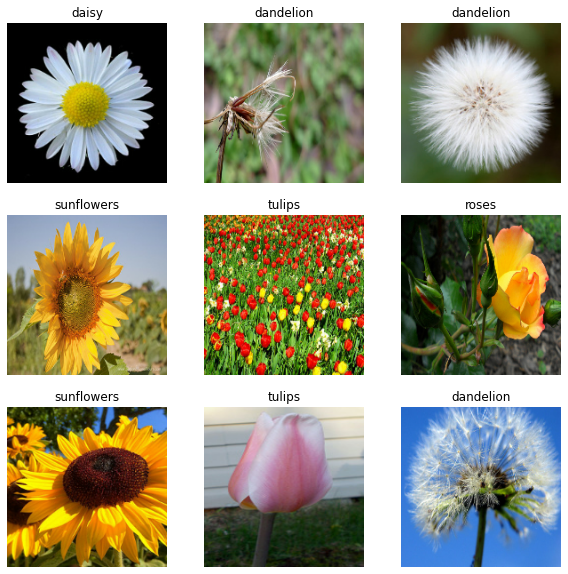

In [27]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

### train model

In [28]:
# the dataset created with tf.data.Dataset is similar to the one created with keras.preprocessing
# we can continue train the model with this dataset
model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
92/92 [==============================] - 4s 43ms/step - loss: 0.7956 - accuracy: 0.7010 - val_loss: 0.7513 - val_accuracy: 0.7125
Epoch 2/3
92/92 [==============================] - 3s 37ms/step - loss: 0.6456 - accuracy: 0.7520 - val_loss: 0.7495 - val_accuracy: 0.6948
Epoch 3/3
92/92 [==============================] - 3s 37ms/step - loss: 0.4530 - accuracy: 0.8341 - val_loss: 0.8004 - val_accuracy: 0.6935


&lt;tensorflow.python.keras.callbacks.History at 0x1e98c88a970&gt;

# Use TensorFlow Datasets

In [30]:
# can also load datasets from TensorFlow Datasets
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers', # the flower dataset
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True
)

█▎        | 28/218 [00:02&lt;00:17, 10.69 MiB/s]
Dl Completed...: 100%|██████████| 1/1 [00:24&lt;00:00, 24.14s/ url]
119 examples [00:00, 1188.92 examples/s]

 49%|████▉     | 1814/3670 [00:00&lt;00:00, 9049.67 examples/s]Shuffling and writing examples to C:\Users\kevin\tensorflow_datasets\tf_flowers\3.0.1.incompleteQKUGJQ\tf_flowers-train.tfrecord
Dataset tf_flowers downloaded and prepared to C:\Users\kevin\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [31]:
num_classes = metadata.features['label'].num_classes
num_classes

5

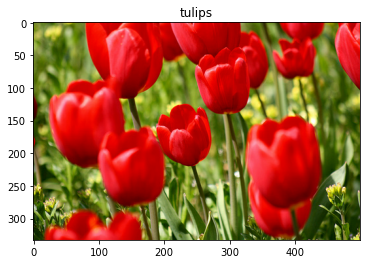

In [32]:
# check an image
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [33]:
# also need to configure dataset
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)